2014 Domain Crawl Analysis
==============

This notebook analyses the 2014 domain crawl, based on a transformed version of the crawl log.

We parsed the `crawl.log` to a series of JSON-formatted entries like:

    {
        "ip": {
            "72.52.4.119": 2
        },
        "tld": "uk",
        "virus": {},
        "host": "eastcoastribs.co.uk",
        "mime": {
            "text/html": 1,
            "text/plain": 1
        },
        "2ld": "co"
    }

A sample of which is in the file `2014-crawl-log-sample.json`. The full output resides in HDFS and we use the `python-webhdfs` library to read this in.

**NOTE**: the below pulls the entire dataset from HDFS; if you want to quickly test, use the commented code that reads in `2014-crawl-log-sample.json`.

Wish List
----------

* **% .uk domain and non-uk**
* **Type of second level domain – so what %  .co.uk, .org.uk , .ac.uk etc    (and the same info if available for non-UK domain sites  .com, .org etc)**
* Main language of website: English vs other
* Institution/commercial vs individual / personal
* **Location – geographical spread across UK (by country, region, north-south)    (where are most heavily represented regions / cities, where are the lowest) – and maybe based on mapping to income levels % in more wealthy areas vs % in low-income areas.**
* If possible, map locations to cities and towns to calculate % urban vs rural.
* Type of content: % mainly textual,  % of sites with audio / visual content
* % freely available/open access vs % subscription / paywall protected
* Frequency of updates:  % of sites updated daily or more vs fairly static
* **Compared to previous year’s crawl: % still active/live  (there in 2014, still there in 2015), % new  (not there in 2014, there in 2015) , % defunct/disappeared (ie. there in 2014 but gone in 2015)**
* Size: % 100 pages or more vs % less than 100 pages  (or whatever number is most meaningful)   (flat vs deep)
* **Largest sites in terms of no. of pages.  (or other measure of size if appropriate)**
* What percentage of UK webspace is occupied by largest sites vs percentage occupied by small sites    (idea would be something similar to a breakdown of wealth eg. top 10% own 45% of GDP, poorest 10% own 2% of GDP.)
* Most linked to; location of links – eg. % with primarily UK links, % with primarily international links
* Countries most linked outside UK domain  (and by region US, Europe, Asia…)
* **Year on year change in number of sites, size of sites or any of the above.**
* Target audience by age range:   all /adults,   youth,   children,  older people.   (any other social demographics that can be gleaned – ethnicity?)
* File types – sound,  video,  pdfs.

Built with help from
----------------------

* <http://introtopython.org/visualization_earthquakes.html>
* <http://web.stanford.edu/~mwaskom/software/seaborn/>

Loading the data
------------------

In [50]:
import json
import webhdfs
import geoip2.database
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
import numpy as np
import string
import pandas as pd
import seaborn
from collections import Counter
from collections import OrderedDict
from geoip2.errors import AddressNotFoundError
from mpl_toolkits.basemap import Basemap 
%matplotlib inline

tlds = Counter()
slds = Counter()
lat_lon = []
host_sizes = {}


def loader(source):
    reader = geoip2.database.Reader("GeoLite2-City.mmdb")
    for line in source:
        host = json.loads(line)
        tlds.update([host["tld"]])
        if "2ld" in host.keys():
            slds.update([host["2ld"]])
        #if host["tld"] == "uk":
        for ip in host["ip"].keys():
            try:
                response = reader.city(ip)
                lat_lon.append((response.location.latitude, response.location.longitude))
            except AddressNotFoundError:
                pass
        host_sizes[host["host"]] = sum(host["mime"].values())
    reader.close()

# Load the test data:
#with open("2014-crawl-log-sample.json", "r") as i:
#    loader(i)

# Load the full crawl data:
#w = webhdfs.API(prefix="http://194.66.232.90:14000/webhdfs/v1", user="heritrix")
#loader(w.readlines("/user/heritrix/2014-domain-crawl-json-formatted/", decompress=True))

print("Loaded.")

Loaded.


## % .uk domain and non-uk

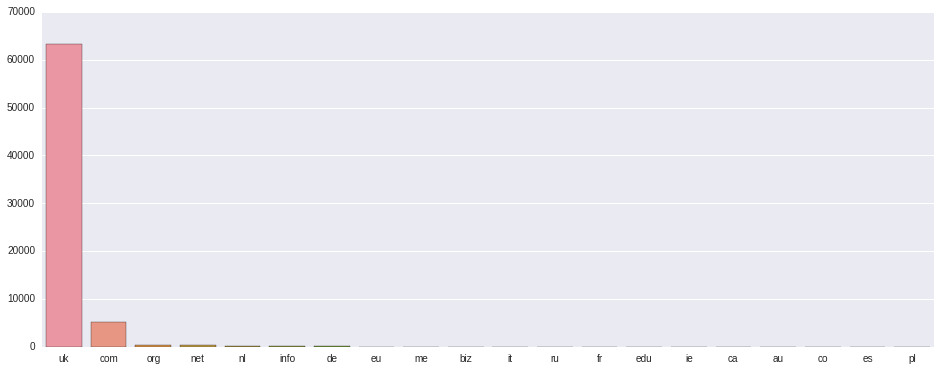

In [77]:
for tld, count in tlds.items():
    if ":" in tld:
        val = tlds.pop(tld)
        tlds[tld.split(":")[0]] += val

tld_labels = list(tlds.keys())
tld_total = sum(list(tlds.values()))
tld_fractions = [float(value)/float(tld_total) for value in tlds.values()]
tld_explode = [1 for l in tld_labels]

tlds_sorted = OrderedDict(sorted(tlds.items(), key=lambda x: x[1], reverse=True))

#plt.axis("equal")
#plt.pie(tld_fractions, labels=tld_labels, shadow=False, explode=tld_explode, autopct="%1.1f%%")

fig = plt.figure(figsize=(16,6))

# Plot up to 15
tldc = 20
if(len(tlds_sorted) < tldc):
    tldc = len(tlds_sorted)

seaborn.set_style("darkgrid")
seaborn.barplot(range(tldc), tlds_sorted.values()[:tldc])

plt.xticks(range(tldc), tlds_sorted.keys()[:tldc])
plt.show()


The above shows that things are very heavily skewed to `.uk` and `.com`. We can switch to a logarithmic scale to make things a bit clearer:

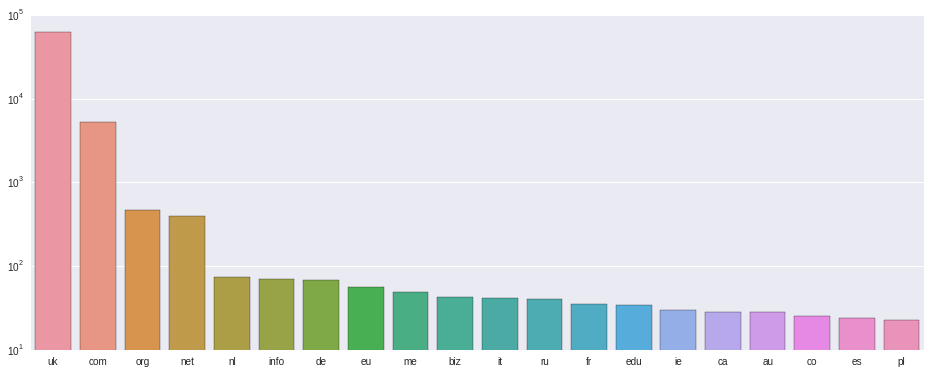

In [78]:
fig = plt.figure(figsize=(16,6))

seaborn.barplot(range(tldc), tlds_sorted.values()[:tldc])

plt.xticks(range(tldc), tlds_sorted.keys()[:tldc])
plt.yscale('log')
plt.show()


## Type of second level domain – so what % .co.uk, .org.uk , .ac.uk etc

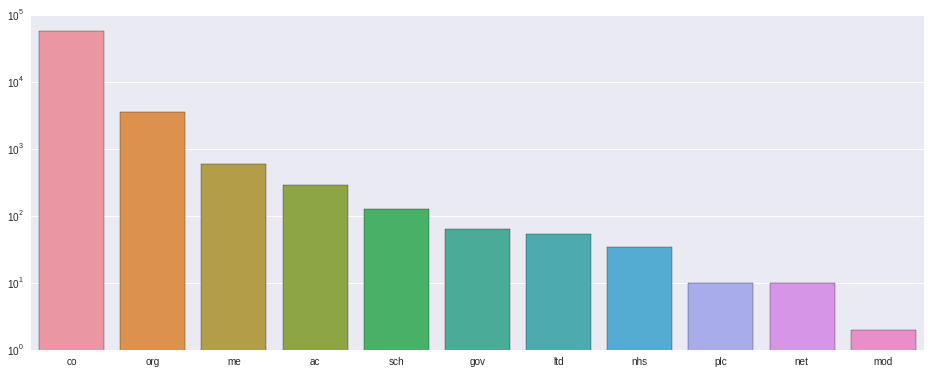

In [79]:
slds_sorted = OrderedDict(sorted(slds.items(), key=lambda x: x[1], reverse=True))

fig = plt.figure(figsize=(16,6))

seaborn.barplot(range(len(slds_sorted)), slds_sorted.values()[:tldc])

plt.xticks(range(len(slds_sorted)), slds_sorted.keys()[:tldc])
plt.yscale('log')
plt.show()


## Geolocation

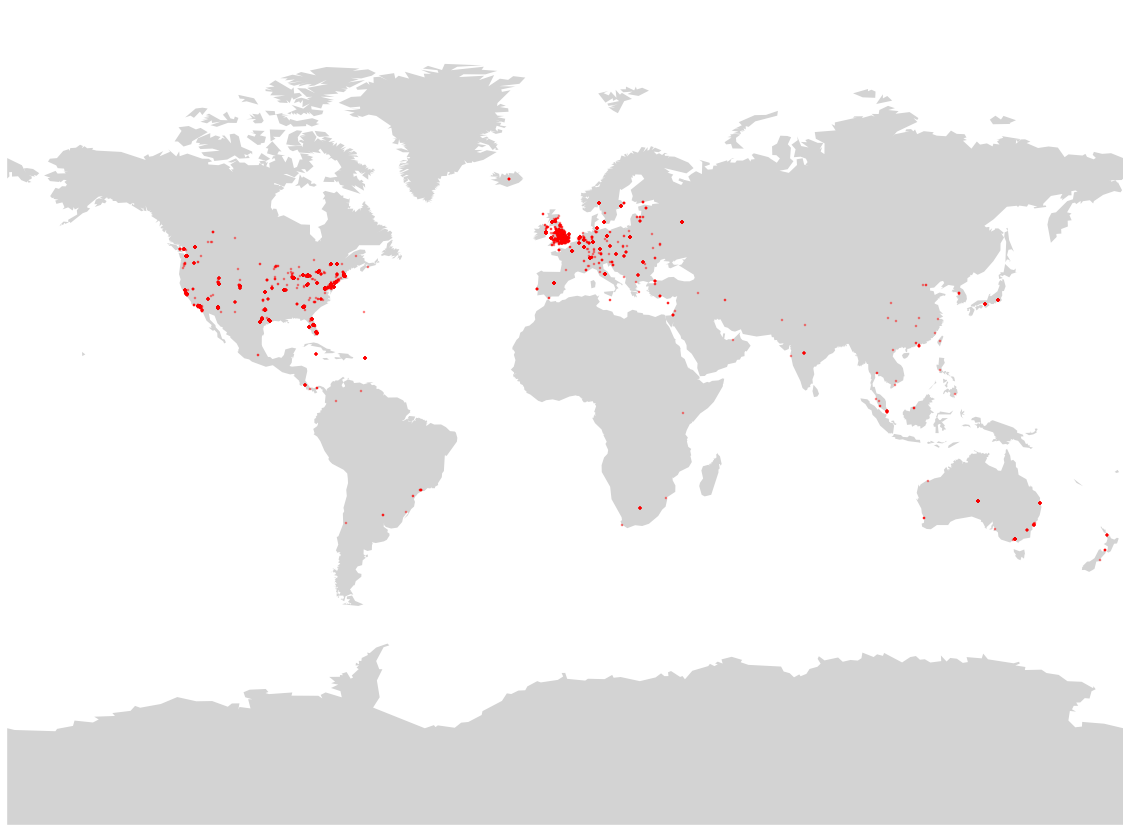

In [80]:
lat_y = [lat for lat, lon in lat_lon if lat is not None]
lon_x = [lon for lat, lon in lat_lon if lon is not None]

# Reset the plot colours for the map plots:
seaborn.set(rc={'axes.facecolor':'none', 'figure.facecolor':'none'})

fig = plt.figure(figsize=(20,16))

m = Basemap(projection='mill',lon_0=0)
#m = Basemap(llcrnrlon=-8.0,llcrnrlat=54.5,urcrnrlon=1.5,urcrnrlat=59.5,lat_ts=20,
#            resolution='h',projection='merc',lon_0=-4.36,lat_0=54.5)

#m.drawcoastlines(color='gray')
#m.drawcountries(color='gray')
m.fillcontinents(color='lightgrey')
#m.drawmapboundary(fill_color='white') # fill to edge
#m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0]) # draw parallels
#m.drawmeridians(np.arange(0.,420.,60.),labels=[0,0,0,1]) # draw meridians

x1,y1=m(lon_x,lat_y)
#m.scatter(x1,y1,s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
m.plot(x1,y1, 'r.', markersize=5, alpha=0.5)


plt.savefig('2014-ldwa-map.png', bbox_inches='tight', dpi=150)
plt.savefig('2014-ldwa-map.pdf', bbox_inches='tight')

plt.show()

The above graph can be downloaded in [PNG](./2014-ldwa-map.png) or [PDF](./2014-ldwa-map.pdf) formats. 

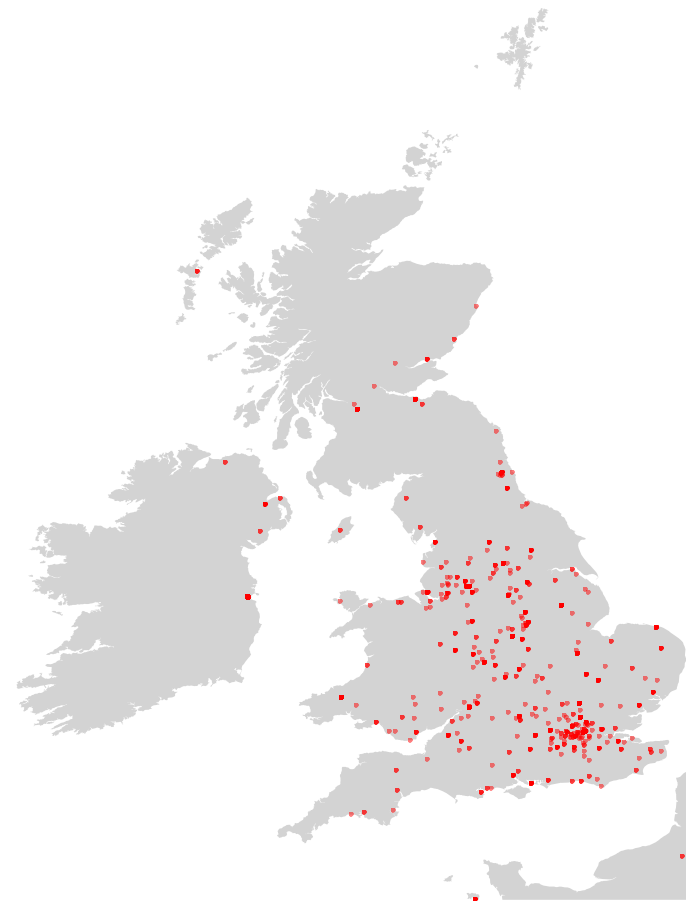

In [ ]:
# Set up a UK bounding box:
bbox = {
  'lon': -5.23636,
  'lat': 53.866772,
  'll_lon': -10.65073,
  'll_lat': 49.16209,
  'ur_lon': 1.76334,
  'ur_lat': 60.860699
}

# Reset the plot colours for the map plots:
seaborn.set(rc={'axes.facecolor':'none', 'figure.facecolor':'none'})

fig = plt.figure(figsize=(20,16))

m = Basemap(
  projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
  llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
  urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'], resolution='h')

#m.drawcoastlines(color='gray')
#m.drawcountries(color='gray')
m.fillcontinents(color='lightgrey')

x1,y1=m(lon_x,lat_y)
#m.scatter(x1,y1,s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
m.plot(x1,y1, 'r.', markersize=10, alpha=0.5)

plt.savefig('2014-ldwa-uk-map.png', bbox_inches='tight', dpi=150)
plt.savefig('2014-ldwa-uk-map.pdf', bbox_inches='tight')

plt.show()

The above graph can be downloaded in [PNG](./2014-ldwa-uk-map.png) or [PDF](./2014-ldwa-uk-map.pdf) formats. 

In [ ]:
# Reset the plot colours for the map plots:
seaborn.set(rc={'axes.facecolor':'none', 'figure.facecolor':'none'})

fig = plt.figure(figsize=(14,14))

# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
map = Basemap(projection='ortho', lat_0=30, lon_0=0,
              resolution='l', area_thresh=1000.0)
 
#map.drawcoastlines(color='gray', linewidth=0.25)
#map.drawcountries(linewidth=0.25)
map.fillcontinents(color='lightgrey',lake_color='white')
# draw the edge of the map projection region (the projection limb)
#map.drawmapboundary(fill_color='aqua')

x,y = map(lon_x,lat_y)
map.plot(x, y, 'r.', markersize=5, alpha=0.5)

plt.savefig('2014-ldwa-globe-map.png', bbox_inches='tight', dpi=150)
plt.savefig('2014-ldwa-globe-map.pdf', bbox_inches='tight')

plt.show()

The above graph can be downloaded in [PNG](./2014-ldwa-globe-map.png) or [PDF](./2014-ldwa-globe-map.pdf) formats. 

## Largest sites in terms of no. of pages.

In [ ]:
hosts_by_size = sorted(host_sizes.items(), key=lambda x:x[1])[-20:]
hosts_by_size.reverse()
print "\n".join([host for (host, size) in hosts_by_size])

It's not clear how meaningful the above list is. Those sites with many resources may just be link farms or other search-engine spamming attempts.